In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("../..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
import jax_smi
jax_smi.initialise_tracking()
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf", from_type="gemma", load_eager=True, device_map="tpu:0")

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [5]:
from sprint.icl_sfc_utils import Circuitizer

In [6]:
from sprint.task_vector_utils import load_tasks, ICLRunner
tasks = load_tasks()

In [7]:
task_names = ["en_es", "antonyms", "person_profession"]
task_name = task_names[0]

In [8]:
import json

with open("cleanup_results.jsonl") as f:
    lines = f.readlines()
    results = [json.loads(line) for line in lines]

In [9]:
def check_if_single_token(token):
    return len(tokenizer.tokenize(token)) == 1

task = tasks[task_name]

print(len(task))

task = {
    k:v for k,v in task.items() if check_if_single_token(k) and check_if_single_token(v)
}


pairs = list(task.items())

batch_size = 8 
n_shot=16
max_seq_len = 128
seed = 10

prompt = "Follow the pattern:\n{}"

runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot, max_seq_len=max_seq_len, seed=seed, prompt=prompt)


layers = list(range(6, 17))
circuitizer = Circuitizer(llama, tokenizer, runner, layers, prompt)

719


Setting up masks...
Running metrics...
Setting up RMS...


  0%|          | 0/18 [00:00<?, ?it/s]

Loading SAEs...


  0%|          | 0/11 [00:00<?, ?it/s]

Running node IEs...


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
import numpy as np
thresholds = np.logspace(-5, 0, 100)
topks = [4, 6, 12, 16, 24, 32]


ablated_metrics, n_nodes_counts = circuitizer.run_ablated_metrics(thresholds, inverse=True, sae_types=["attn_out"], layers=[12])


# target_metric = (max(ablated_metrics) - min(ablated_metrics)) * 0.95 + min(ablated_metrics)
# target_threshold = [threshold for threshold, metric in reversed(list(zip(thresholds, ablated_metrics))) if metric > target_metric][0]

  0%|          | 0/100 [00:00<?, ?it/s]

[<matplotlib.lines.Line2D at 0x7f90c41a3670>]

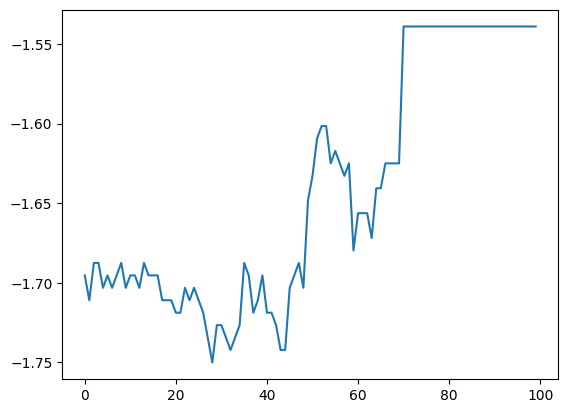

In [24]:
import matplotlib.pyplot as plt

plt.plot(ablated_metrics)
# plt.xscale("log")

In [26]:
from tqdm.auto import tqdm

ams = []

for layer in tqdm(circuitizer.layers):
    ablated_metrics, n_nodes_counts = circuitizer.run_ablated_metrics(thresholds, inverse=True, sae_types=["attn_out"], layers=[layer])
    ams.append(ablated_metrics)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
[min(x) for x in ams]

[-1.609375,
 -1.5234375,
 -1.5234375,
 -1.5390625,
 -1.5859375,
 -1.6484375,
 -1.75,
 -3.28125,
 -1.5390625,
 -1.6328125,
 -1.546875]

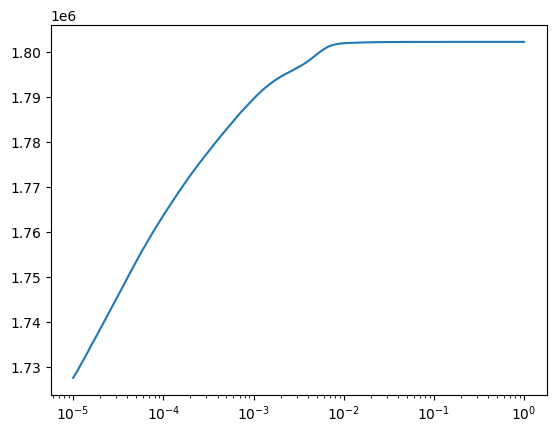

In [16]:
plt.plot(thresholds, n_nodes_counts)
plt.xscale("log")

In [111]:
ablated_metrics[22]

-5.25

In [112]:


mask_attn_out_1, n_nodes_attn = circuitizer.mask_ie(circuitizer.ie_attn[11], thresholds[22], None, inverse=True)
mask_attn_out_2, n_nodes_attn = circuitizer.mask_ie(circuitizer.ie_attn[11], thresholds[-1], None, inverse=True)

In [113]:
removed_features_attn_mask = mask_attn_out_2["arrow"].astype(np.int32) -  mask_attn_out_1["arrow"].astype(np.int32)
removed_features_attn_mask = removed_features_attn_mask == 1

In [114]:
removed_features_attn_mask.sum()

<jax.Array(57, dtype=int32)>

In [115]:
removed_features_attn = circuitizer.saes[(12, "resid")]["W_dec"][removed_features_attn_mask]

In [116]:
removed_features_attn = removed_features_attn / np.linalg.norm(removed_features_attn, axis=1, keepdims=True)

pairwise_sims = removed_features_attn @ removed_features_attn.T



In [102]:
%pip install -U kaleido

/usr/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 14.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [118]:
import plotly.express as px
import plotly.io as pio

fig = px.imshow(pairwise_sims, width=800, height=800)
# pio.write_image(fig, "pairwise_sims.png")

fig

In [10]:
features = [9790, 12605, 13458, 11491, 18803, 2931, 11618, 26987, 5679, 15554, 26594]

In [11]:
from sprint.icl_sfc_utils import AblatedModule
layer = 12
mask_name = "arrow"

In [51]:
task_results = [result for result in results if result["task"] == task_name]

In [75]:
len(task_results)

8

In [72]:
import jax.numpy as jnp

layer_masks = {}

resid = circuitizer.saes[(12, "resid")]


for r in task_results:
    layer = r["layer"]
    w = np.array(r["weights"])
    f_ids = jnp.nonzero(w * (w > 0))

    feature = features[0]

    mask = np.ones(resid["W_dec"].shape[0])
    mask[f_ids] = 0

    mask = jnp.array(mask)

    masks = {
        k: mask for k in circuitizer.masks
    }

    # masks[mask_name] = mask

    layer_masks[layer] = masks



In [73]:
from micrlhf.llama import LlamaBlock

llama_ablated = llama

for layer, masks in layer_masks.items():
    block_selection = llama_ablated.select().at_instances_of(LlamaBlock).pick_nth_selected(layer)

    def converter(block):
        block = block.select().at_instances_of(LlamaBlock).apply(lambda x: pz.nn.Sequential([AblatedModule.wrap(resid, masks, circuitizer.masks), x]))    
        return block

    llama_ablated = block_selection.apply(converter)

In [74]:
print(circuitizer.ablated_metric(llama_ablated))
print(circuitizer.ablated_metric(llama))

-1.6610659
-1.40625


In [18]:
circuitizer.run_ablated_metrics([-1, 0, target_threshold])

  0%|          | 0/3 [00:00<?, ?it/s]

([-1.3984375, -1.4296875, -1.0703125], [5242880, 200719, 118202])

In [20]:
import matplotlib.pyplot as plt

ablated_metrics[:40]

[-1.2734375,
 -1.28125,
 -1.2578125,
 -1.265625,
 -1.171875,
 -1.078125,
 -1.1015625,
 -1.1328125,
 -1.078125,
 -1.1015625,
 -1.1796875,
 -1.171875,
 -1.1953125,
 -1.2109375,
 -1.1875,
 -1.1875,
 -1.1875,
 -1.1796875,
 -1.15625,
 -1.0546875,
 -1.0546875,
 -1.046875,
 -1.078125,
 -1.1328125,
 -1.09375,
 -1.0625,
 -1.1171875,
 -1.140625,
 -1.1015625,
 -1.140625,
 -1.1171875,
 -1.1796875,
 -1.25,
 -1.171875,
 -1.140625,
 -1.09375,
 -1.0078125,
 -1.03125,
 -1.1015625,
 -1.1015625]

In [22]:
logits = llama(circuitizer.llama_inputs)

In [24]:
logits = logits.unwrap("batch", "seq", "vocabulary")

In [26]:
logits = logits.argmax(-1)

In [29]:
logits = logits[:, :-1]

res = logits == circuitizer.train_tokens[:, 1:]

In [31]:
answer_mask = circuitizer.train_tokens[:, 1:] == 3978
answer_mask = np.roll(answer_mask, 1, axis=1)

In [32]:
(res * answer_mask).sum() / answer_mask.sum()

<jax.Array(0.7265625, dtype=float32)>